Let's first load the necessary packages and libraries

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from Graph_Generation.simple_graph_generation import create_delaunay_graph
from Graph_Generation.target_graph import create_fully_connected_target_graph
from Graph_Generation.visibility import line_of_sight_visibility, two_hop_visibility
from Single_Agent.value_iteration import SuboptimalValueIteration

Let's generate the graph (a 2D grid looking graph)


At the moment we have the following graph features


Node Level: 

    - "type": "source", "target_unreached", "target_reached", "intermediate" 

    - "visible_edges": a map from each node to the visible edges 


Note that the node's position is accessed like a 2D array, rather than using an explicit position attribute


Edge Level: 

    - "distance": Euclidian distance of the edge 

    - "observed_edge" : boolean of whether or not the edge was observed 
    
    - "num_used" : an edge value function 

In [2]:
num_nodes = 64
env_graph = create_delaunay_graph(64, target_ratio = 2/64, seed = 12)
_ = two_hop_visibility(env_graph, num_extended_nodes=4)
target_graph = create_fully_connected_target_graph(env_graph)

Let's first visualize the environment graph

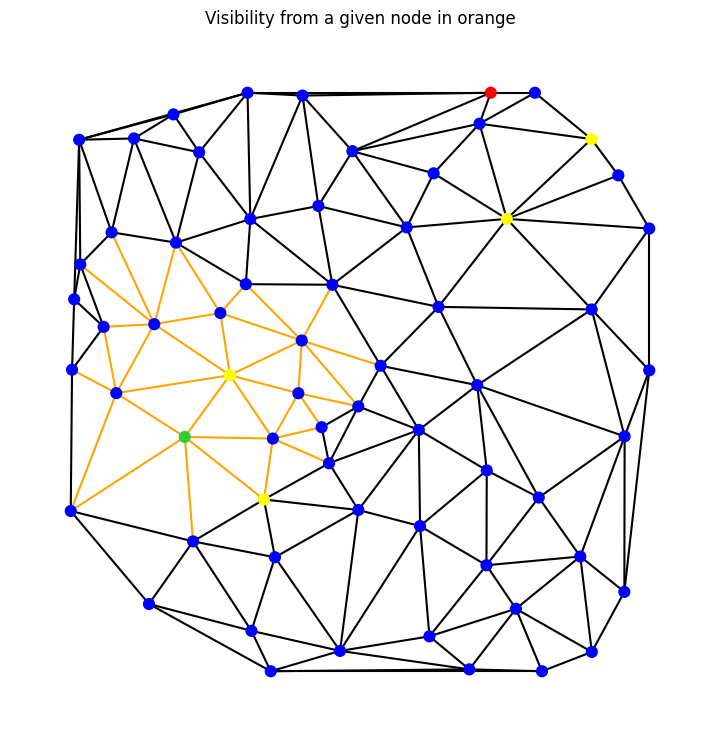

In [3]:
extended_nodes = [node for node in env_graph.nodes() 
                  if env_graph.nodes[node].get('has_extended_visibility', True)]
non_extended_nodes = [node for node in env_graph.nodes() 
                  if env_graph.nodes[node].get('has_extended_visibility', False)]

source_node = extended_nodes[0] if extended_nodes else non_extended_nodes[0]
visible_edges = env_graph.nodes[source_node]['visible_edges']

# Get positions from node attributes
pos = nx.get_node_attributes(env_graph, 'pos')

# Create a list of colors based on node attributes
color_map = []
for node, data in env_graph.nodes(data=True):
    if data["type"] == "source":
        color_map.append("limegreen")  # Use a vibrant green for the source
    elif data["type"] == "target_unreached":
        color_map.append("red")
    elif node in extended_nodes:
        color_map.append("yellow")
    else:
        color_map.append("blue")

edge_color = []
for u, v, data in env_graph.edges(data=True):
    edge_tuple = tuple(sorted((u, v)))
    if edge_tuple in visible_edges:
        # Style for visible edges: orange
        edge_color.append('orange')
    else:
        # Style for invisible edges: black
        edge_color.append('black')

# Draw the graph with updated styles
plt.figure(figsize=(7, 7))
nx.draw(
    env_graph,
    pos=pos,
    node_color=color_map, 
    with_labels=False,
    node_size=60,
    width=1.5,
    edge_color=edge_color
)

plt.title("Visibility from a given node in orange")
plt.show()

Let's also visulize the target graph and the 'num_used' weights

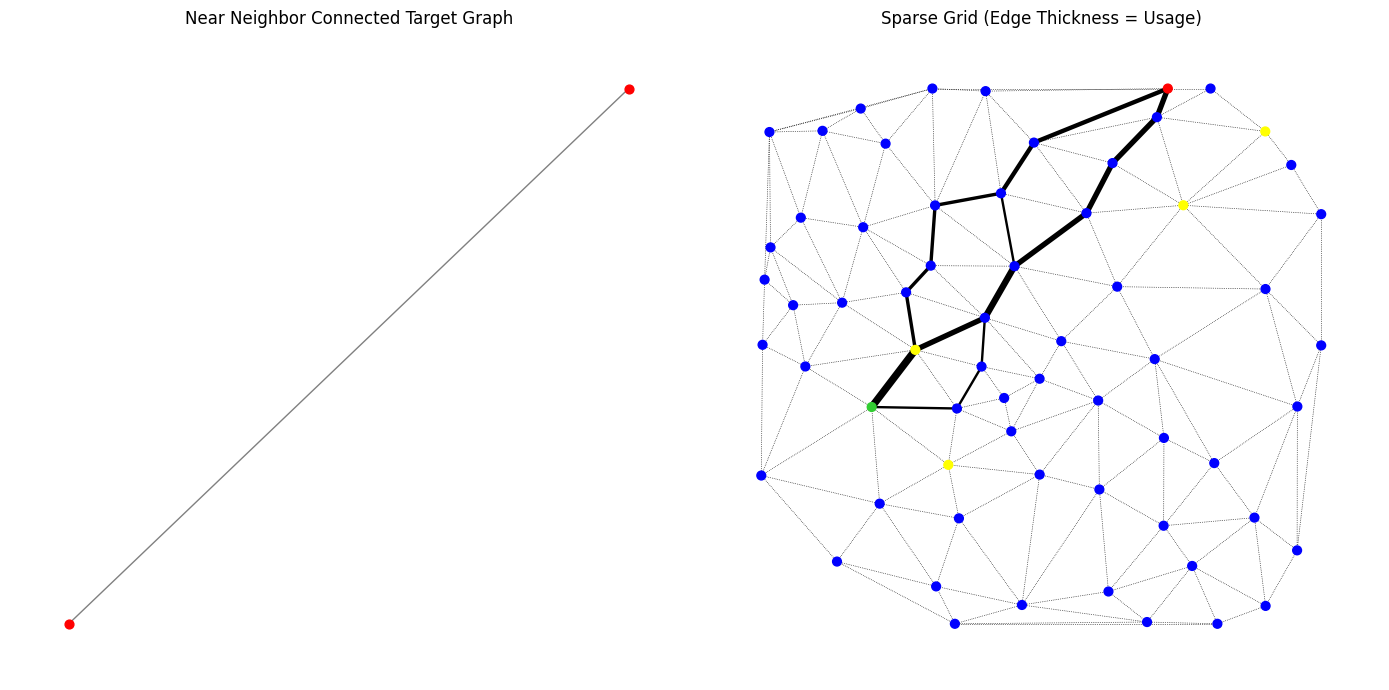

In [4]:
# --- 1. Prepare for Plotting ---

# Get positions from node attributes
pos = nx.get_node_attributes(env_graph, 'pos')

extended_nodes = [node for node in env_graph.nodes() 
                  if env_graph.nodes[node].get('has_extended_visibility', True)]

color_map = []
for node, data in env_graph.nodes(data=True):
    if data["type"] == "source":
        color_map.append("limegreen")  # Use a vibrant green for the source
    elif data["type"] == "target_unreached":
        color_map.append("red")   
    elif node in extended_nodes:
        color_map.append("yellow")
    else:
        color_map.append("blue")

# --- 2. Create Dynamic Edge Styles for the Sparse Grid ---

edge_widths = []
edge_styles = []
for u, v, data in env_graph.edges(data=True):
    num_used = data.get('num_used', 0)
    if num_used > 0:
        # Style for used edges: solid and thicker based on usage count
        edge_styles.append('solid')
        edge_widths.append(1.0 + 5.0 * num_used)  # Scaled for visibility
    else:
        # Style for unused edges: dotted and thin
        edge_styles.append('dotted')
        edge_widths.append(0.5)

# --- 3. Create the Side-by-Side Plot (in the new order) ---

# Create a figure and a set of subplots (1 row, 2 columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

# --- Plot 1: Fully Connected Target Graph (NOW on the left axis) ---
axes[0].set_title("Near Neighbor Connected Target Graph")
nx.draw(
    target_graph,
    pos=pos,
    ax=axes[0],  # Draw on the left subplot
    node_color="red",
    with_labels=False,
    node_size=40,
    width=1.0,
    edge_color='grey'
)

# --- Plot 2: Original Sparse Grid with Usage (NOW on the right axis) ---
axes[1].set_title("Sparse Grid (Edge Thickness = Usage)")
nx.draw(
    env_graph,
    pos=pos,
    ax=axes[1],  # Draw on the right subplot
    node_color=color_map,
    with_labels=False,
    node_size=40,
    width=edge_widths,  # Use the dynamic widths
    style=edge_styles   # Use the dynamic styles
)

plt.tight_layout()
plt.show()

Let's now run value iteration to find the optimal path given our reward function

In [5]:
starting_node = [node for node, data in env_graph.nodes(data=True) if data.get("type") == "source"][0]

value_iteration = SuboptimalValueIteration(env_graph=env_graph, s0=starting_node, gamma=0.5)

trajectory = []
trajectory = value_iteration.run()

Initial unreached targets: [17]
Time step 1: Moved to 1, Remaining targets: 1
Time step 2: Moved to 5, Remaining targets: 1
Time step 3: Moved to 12, Remaining targets: 1
Time step 4: Moved to 14, Remaining targets: 1
Time step 5: Moved to 16, Remaining targets: 1
Time step 6: Moved to 17, Remaining targets: 0


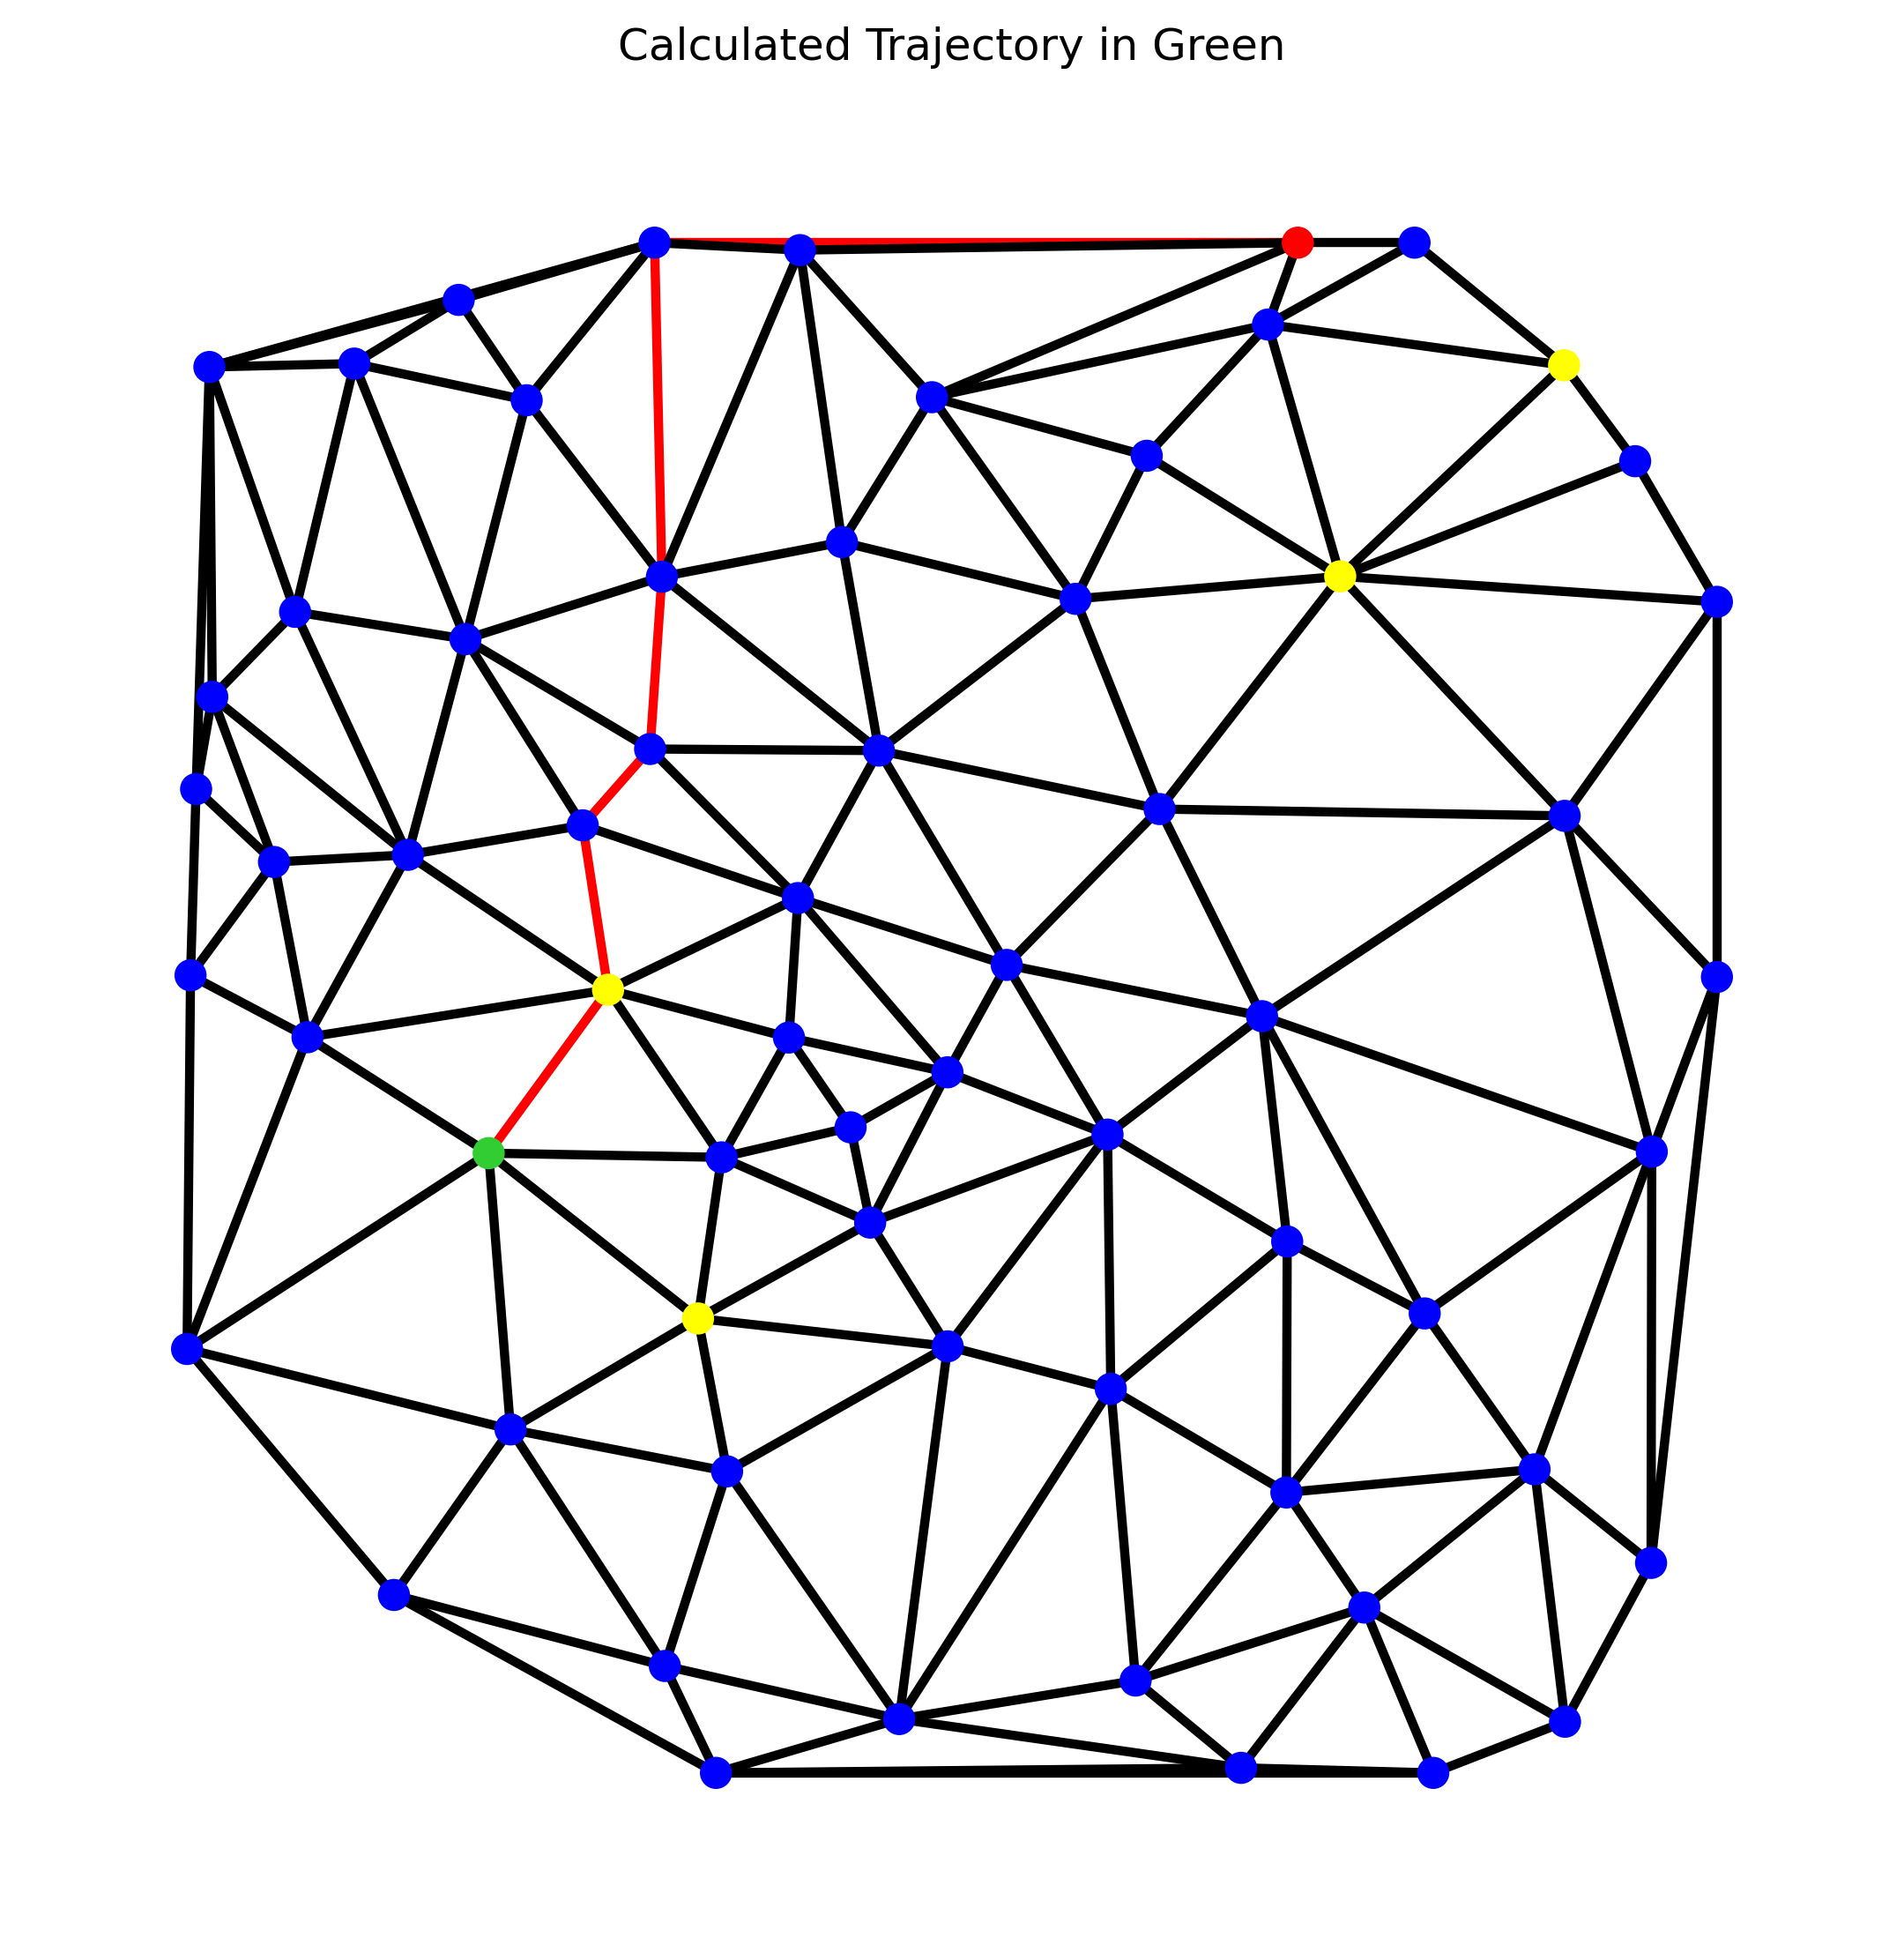

In [7]:
trajectory_edges = {tuple(sorted((u, v))) for u, v in trajectory}

# Get positions from node attributes
pos = nx.get_node_attributes(env_graph, 'pos')

extended_nodes = [node for node in env_graph.nodes() 
                  if env_graph.nodes[node].get('has_extended_visibility', True)]

color_map = []
for node, data in env_graph.nodes(data=True):
    if data["type"] == "source":
        color_map.append("limegreen")  # Use a vibrant green for the source
    elif data["type"] == "target_reached":
        color_map.append("red")   
    elif node in extended_nodes:
        color_map.append("yellow")
    else:
        color_map.append("blue")

edge_color = []
for u, v, data in env_graph.edges(data=True):
    edge_tuple = tuple(sorted((u, v)))
    if edge_tuple in trajectory_edges:
        edge_color.append('red')
    else:
        # Style for invisible edges: black
        edge_color.append('black')

node_labels = {s: f"{v:.2f}" for s, v in value_iteration.V_t.items()}

# Draw the graph with updated styles
plt.figure(figsize=(7, 7), dpi=300)
nx.draw(
    env_graph,
    pos=pos,
    node_color=color_map,
    with_labels=False, 
    labels=node_labels,
    node_size=60,
    width=2.5,
    edge_color=edge_color,
)

plt.title("Calculated Trajectory in Green")
plt.show()